## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
import pickle
from sklearn.model_selection import train_test_split

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load cleaned data

In [2]:
data = pd.read_csv("data/cleaned_static_features.csv",index_col=0)
with open("data/groups.pkl", 'rb') as file:
    groups = pickle.load(file)

In [3]:
data

,participant_id,session_id,task_name,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,range_ratio_intensity_db,std_hnr_db,stoi,pesq,si_sdr,Voice Disorders,Neurological and Neurodegenerative Disorders,Mood and Psychiatric Disorders,Respiratory Disorders,participant_id_int
0,004d42e9,07031CC3,Animal-fluency,30.849073,0.205649,26.938833,32.299248,36.319099,9.380266,321.246490,...,2.522056,6.754861,0.594471,1.159233,-14.364435,0,1,1,0,0
26,004d42e9,07031CC3,Productive-Vocabulary-1,34.447186,0.057132,32.960548,33.506256,36.057877,3.097328,100.624840,...,2.078612,7.996467,0.802794,1.277508,-0.301972,0,1,1,0,0
27,004d42e9,07031CC3,Productive-Vocabulary-2,35.895359,0.092448,33.253757,35.642937,37.830379,4.576622,381.294708,...,1.813655,7.262162,0.742845,1.199748,-1.893810,0,1,1,0,0
28,004d42e9,07031CC3,Productive-Vocabulary-3,35.248405,0.101374,33.987968,36.224056,37.653236,3.665268,85.709679,...,2.088298,7.535089,0.705393,1.185849,-3.215629,0,1,1,0,0
29,004d42e9,07031CC3,Productive-Vocabulary-4,33.798946,0.114689,32.843185,34.022396,36.028976,3.185791,158.320511,...,1.864071,6.776752,0.818446,1.240876,-1.725452,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19245,ff75b163,6A3E7090,Diadochokinesis-TA,26.530842,0.038758,25.860199,26.675362,27.344505,1.484306,28.920113,...,2.304262,4.338372,0.993067,3.620620,25.058619,1,0,0,0,441
19246,ff75b163,6A3E7090,Diadochokinesis-buttercup,27.925495,0.054326,27.288794,28.198372,28.900181,1.611387,76.308060,...,2.489648,2.995060,0.943791,2.379631,17.349405,1,0,0,0,441
19247,ff75b163,6A3E7090,Free-Speech,25.366678,0.090976,23.924431,25.256680,26.426678,2.502247,136.878525,...,2.359750,4.772076,0.898831,1.960933,12.243779,1,0,0,0,441
19249,ff75b163,6A3E7090,Free-speech-2,26.703327,0.166226,24.957359,26.008017,27.915869,2.958509,188.426971,...,2.459517,6.370732,0.869760,1.683203,6.723745,1,0,0,0,441


In [4]:
groups

array([  0,   0,   0, ..., 441, 441, 441], shape=(19238,))

## Reshape data

In [5]:
disorders = ["Voice Disorders", "Neurological and Neurodegenerative Disorders", "Mood and Psychiatric Disorders","Respiratory Disorders"]


y_voice = data["Voice Disorders"].copy().to_numpy()
y_neuro = data["Neurological and Neurodegenerative Disorders"].copy().to_numpy()
y_psych = data["Mood and Psychiatric Disorders"].copy().to_numpy()
y_resp = data["Respiratory Disorders"].copy().to_numpy()
X = data.copy().drop(columns=["participant_id", "session_id","task_name"]+disorders).to_numpy()

In [6]:
X.shape

(19238, 97)

In [7]:
y_voice.shape

(19238,)

## Average over sessions within subject

In [8]:
n_subj = groups[-1]+1
X_ave = np.zeros((n_subj, X.shape[1]))
y_voice_ave = np.zeros(n_subj)
y_neuro_ave = np.zeros(n_subj)
y_psych_ave = np.zeros(n_subj)
y_resp_ave = np.zeros(n_subj)
for g in np.arange(n_subj):
    curr_X = X[np.where(groups==g)].mean(axis=0)
    X_ave[g] = curr_X
    y_voice_ave[g] = y_voice[np.where(groups==g)].mean()
    y_neuro_ave[g] = y_neuro[np.where(groups==g)].mean()
    y_psych_ave[g] = y_psych[np.where(groups==g)].mean()
    y_resp_ave[g] = y_resp[np.where(groups==g)].mean()
print(X_ave.shape)

(442, 97)


## Normalization

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_proc = ss.fit_transform(X)
X_proc

array([[ 0.35671517,  1.22982296,  0.23126498, ..., -0.9498115 ,
        -1.11640847, -1.70446606],
       [ 0.6293551 , -0.40929   ,  0.71729659, ..., -0.83189516,
        -0.21137239, -1.70446606],
       [ 0.73908762, -0.01952797,  0.74096242, ..., -0.90941962,
        -0.3138204 , -1.70446606],
       ...,
       [-0.05870263, -0.03576868, -0.01203694, ..., -0.15054014,
         0.59605065,  1.70435918],
       [ 0.04257933,  0.79472738,  0.07133398, ..., -0.42742919,
         0.24079072,  1.70435918],
       [-0.03307289,  0.09295254,  0.05313916, ..., -0.56574048,
         0.18794105,  1.70435918]], shape=(19238, 97))

## Train random forest model for each disorder class

In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
import warnings

warnings.filterwarnings('ignore')

disorder_labels = ["Voice","Neuro","Psych","Resp"]

y_all = [y_voice_ave, y_neuro_ave, y_psych_ave, y_resp_ave]

cv_results = {}

for curr_y,disorder_label in zip(y_all, disorder_labels):

    train_f1s = []
    val_f1s = []

    X_train, X_test, y_train, y_test = train_test_split(X_ave, curr_y, test_size=0.15, random_state=42)

    # 10-fold Stratified CV on the train+val set to produce validation scores
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    model = RandomForestClassifier()

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Work with a fresh clone of the estimator for each fold
        est = clone(model)
        est.fit(X_tr, y_tr)

        y_tr_pred = est.predict(X_tr)
        y_val_pred = est.predict(X_val)

        tr_f1 = f1_score(y_tr, y_tr_pred, average="weighted")
        val_f1 = f1_score(y_val, y_val_pred, average="weighted")

        train_f1s.append(tr_f1)
        val_f1s.append(val_f1)

    cv_results[disorder_label] = {
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
    }

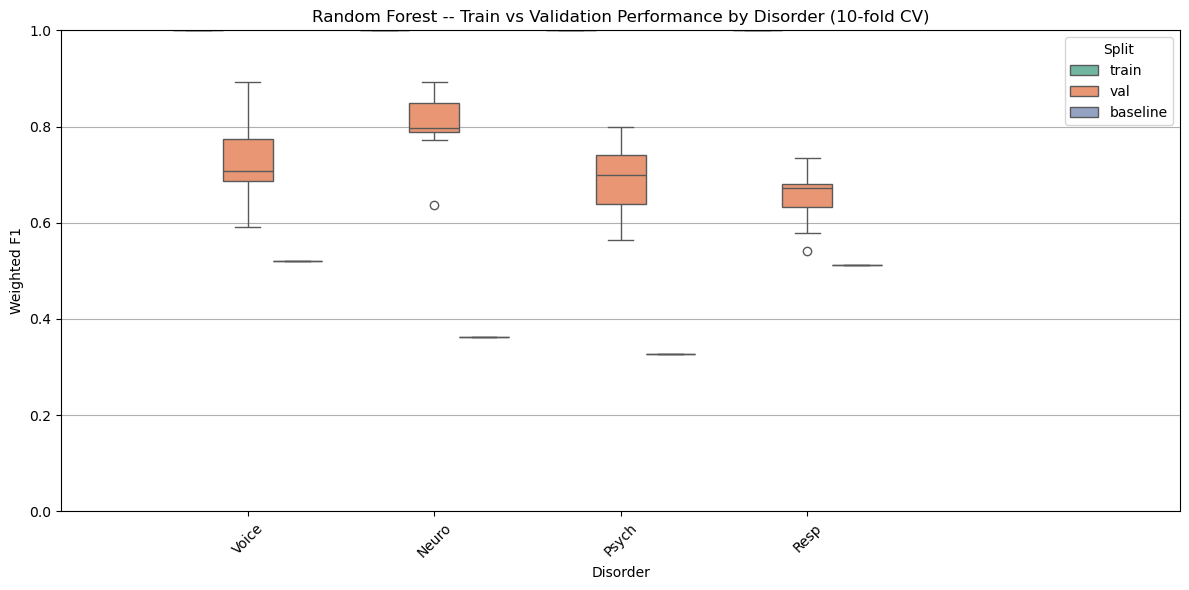


CV summary (mean ± std) and test weighted F1 (10-fold CV):
model  train_f1_mean  train_f1_std  val_f1_mean  val_f1_std
Voice            1.0           0.0     0.726037    0.077310
Neuro            1.0           0.0     0.802824    0.069470
Psych            1.0           0.0     0.693045    0.073186
 Resp            1.0           0.0     0.655786    0.057503


In [11]:
# Grouped boxplot: training vs validation F1 per model (10-fold CV)
import seaborn as sns

# Build long-form DataFrame with one row per fold per model/split
rows = []
for d,curr_y in zip(disorder_labels,y_all):
    for v in cv_results[d]['train_f1s']:
        rows.append({'disorder': d, 'split': 'train', 'f1': v})
    for v in cv_results[d]['val_f1s']:
        rows.append({'disorder': d, 'split': 'val', 'f1': v})
        rows.append({'disorder': d, 'split': 'baseline', 'f1':curr_y.mean()})

plot_df = pd.DataFrame(rows)

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='disorder', y='f1', hue='split', data=plot_df, palette='Set2')
ax.set_title('Random Forest -- Train vs Validation Performance by Disorder (10-fold CV)')
ax.set_ylabel('Weighted F1')
ax.set_xlabel('Disorder')
ax.set_xlim([-1, 5])
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Split')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Summary statistics table (mean ± std) for convenience
summary_rows = []
for d in disorder_labels:
    train_mean = np.mean(cv_results[d]['train_f1s'])
    train_std = np.std(cv_results[d]['train_f1s'])
    val_mean = np.mean(cv_results[d]['val_f1s'])
    val_std = np.std(cv_results[d]['val_f1s'])
    summary_rows.append({'model': d,
                         'train_f1_mean': train_mean,
                         'train_f1_std': train_std,
                         'val_f1_mean': val_mean,
                         'val_f1_std': val_std,
                         })

summary_df = pd.DataFrame(summary_rows)
print('\nCV summary (mean ± std) and test weighted F1 (10-fold CV):')
print(summary_df[['model','train_f1_mean','train_f1_std','val_f1_mean','val_f1_std']].to_string(index=False))

## Hyperparameter tuning for random forest model

#### Voice disorders

Top 5 hyperparameter combinations (by validation rank):
Rank 1: val=0.7782, train=0.9860, params={'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Rank 1: val=0.7782, train=0.9860, params={'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
Rank 3: val=0.7731, train=1.0000, params={'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Rank 4: val=0.7704, train=1.0000, params={'class_weight': 'balanced', 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Rank 5: val=0.7679, train=0.9927, params={'class_weight': None, 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}


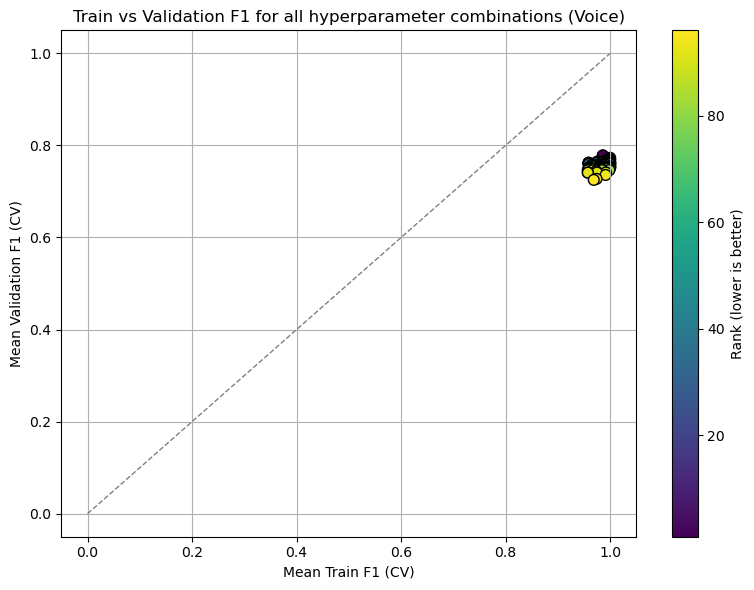

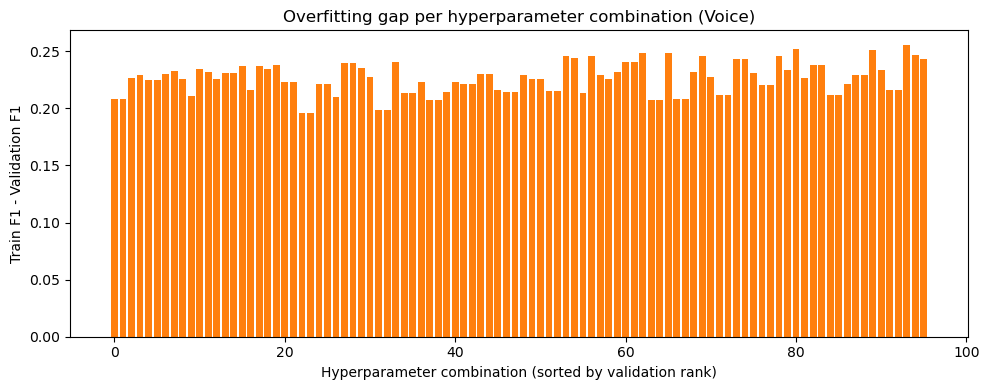

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.66      0.78      0.71        32
         1.0       0.76      0.63      0.69        35

    accuracy                           0.70        67
   macro avg       0.71      0.70      0.70        67
weighted avg       0.71      0.70      0.70        67

Confusion matrix (test):
[[25  7]
 [13 22]]


In [13]:
# Run GridSearchCV only for Voice disorder and visualize all combinations' train vs validation performance
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Slightly smaller grid for Voice-only tuning to keep runtime reasonable while exploring combinations
param_grid = {
    'n_estimators': [50, 200, 500],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 0.5],
    'class_weight': [None, 'balanced'],
}

label = 'Voice'
y_curr = y_voice_ave

# Split off a held-out test set (never used for CV)
X_tr, X_te, y_tr, y_te = train_test_split(X_ave, y_curr, test_size=0.15, random_state=42, stratify=y_curr)

base_rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gscv = GridSearchCV(base_rf, param_grid, scoring='f1_weighted', cv=skf, n_jobs=-1, refit=True, return_train_score=True)
gscv.fit(X_tr, y_tr)

# Convert cv_results_ into a DataFrame for easier analysis
cv_res = pd.DataFrame(gscv.cv_results_)
# keep only relevant cols
cols = ['params','mean_train_score','std_train_score','mean_test_score','std_test_score','rank_test_score']
summary_grid = cv_res[cols].sort_values('rank_test_score').reset_index(drop=True)

print('Top 5 hyperparameter combinations (by validation rank):')
for i, row in summary_grid.head(5).iterrows():
    print(f"Rank {int(row['rank_test_score'])}: val={row['mean_test_score']:.4f}, train={row['mean_train_score']:.4f}, params={row['params']}")

# Scatter plot: train vs validation for every combo
fig, ax = plt.subplots(figsize=(8,6))
x = summary_grid['mean_train_score']
y = summary_grid['mean_test_score']
sc = ax.scatter(x, y, c=summary_grid['rank_test_score'], cmap='viridis', s=60, edgecolor='k')
ax.plot([0,1],[0,1],'--',color='gray',linewidth=1)  # reference line where train==val
ax.set_xlabel('Mean Train F1 (CV)')
ax.set_ylabel('Mean Validation F1 (CV)')
ax.set_title('Train vs Validation F1 for all hyperparameter combinations (Voice)')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Rank (lower is better)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the overfitting gap (train - val) sorted by rank
summary_grid['train_minus_val'] = summary_grid['mean_train_score'] - summary_grid['mean_test_score']
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(summary_grid)), summary_grid['train_minus_val'], color='C1')
ax.set_xlabel('Hyperparameter combination (sorted by validation rank)')
ax.set_ylabel('Train F1 - Validation F1')
ax.set_title('Overfitting gap per hyperparameter combination (Voice)')
plt.tight_layout()
plt.show()

# Evaluate best estimator on held-out test set and show report
best = gscv.best_estimator_
y_test_pred = best.predict(X_te)
test_f1 = f1_score(y_te, y_test_pred, average='weighted')
print('Classification report (test):')
print(classification_report(y_te, y_test_pred))
print('Confusion matrix (test):')
print(confusion_matrix(y_te, y_test_pred))

# Save results to a dict for later use
grid_search_voice = {'cv_results_df': summary_grid, 'best_params': gscv.best_params_, 'best_score_cv': gscv.best_score_, 'test_f1': test_f1, 'best_estimator': best}
